In [1]:
import ast
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 8, 5
sns.set_style('darkgrid')

from IPython.display import display

In [3]:
# Google colab
# file = ''

# Local
# file = ''

In [4]:
# glossary = pd.read_excel(file, sheet_name=0, skiprows=3)
stores_data = pd.read_excel(file, sheet_name=1, skiprows=1)
products_data = pd.read_excel(file, sheet_name=2, skiprows=1)
transactions_data = pd.read_excel(file, sheet_name=3, skiprows=1)

In [5]:
stores_data.head(2)

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,389,SILVERLAKE,ERLANGER,KY,17140,MAINSTREAM,408.0,46073,24766.807692
1,2277,ANDERSON TOWNE CTR,CINCINNATI,OH,17140,UPSCALE,NaN,81958,54052.519231


In [6]:
products_data.head(2)

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ


In [7]:
transactions_data.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY
0,2009-01-14,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,1
1,2009-01-14,367,1111009497,20,18,18,27.80,1.39,1.39,0,0,0


Т.к. в статье не было указано, какими были сегменты, попробуем сами их составить. Кажется, что одними из главных признаков, являются тип магазина и подкатегория товара - с них и начнем.

In [8]:
stores_data['SEG_VALUE_NAME'].unique()

array(['MAINSTREAM', 'UPSCALE', 'VALUE'], dtype=object)

Магазины разбиты на 3 типа:
1. MAINSTREAM - средний сегмент
2. UPSCALE - дорогой сегмент
3. VALUE - дешевый сегмент

In [11]:
print(*products_data['SUB_CATEGORY'].unique(), sep=', ')

PRETZELS, MOUTHWASHES (ANTISEPTIC), ALL FAMILY CEREAL, ADULT CEREAL, PIZZA/PREMIUM, KIDS CEREAL, MOUTHWASH/RINSES AND SPRAYS


Продукты разбиты на 7 подкатегорий, однако объединим:
1. ADULT CEREAL + KIDS CEREAL -> CEREAL
2. MOUTHWASHES (ANTISEPTIC) + MOUTHWASH/RINSES AND SPRAYS -> ANTISEPTIC

In [12]:
merge_rules = {
    'ADULT CEREAL': 'CEREAL',
    'KIDS CEREAL': 'CEREAL',
    'MOUTHWASH/RINSES AND SPRAYS': 'ANTISEPTIC',
    'MOUTHWASHES (ANTISEPTIC)': 'ANTISEPTIC'
}
products_data['SUB_CATEGORY'] = products_data['SUB_CATEGORY'].replace(merge_rules)

In [13]:
transactions_data = transactions_data.merge(stores_data[['STORE_ID', 'SEG_VALUE_NAME']],
                                            how='left', left_on='STORE_NUM', right_on='STORE_ID')
transactions_data = transactions_data.merge(products_data[['UPC', 'SUB_CATEGORY']], how='left', on='UPC')

transactions_data.drop('STORE_ID', axis=1, inplace=True)

In [14]:
ids, names = pd.factorize(transactions_data[['SUB_CATEGORY', 'SEG_VALUE_NAME']].apply(tuple, axis=1))
transactions_data['SEGMENT_ID'] = ids

segment_dict = {i: names[i] for i in range(len(names))}

In [15]:
transactions_data.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,SEG_VALUE_NAME,SUB_CATEGORY,SEGMENT_ID
0,2009-01-14,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,1,VALUE,PRETZELS,0
1,2009-01-14,367,1111009497,20,18,18,27.80,1.39,1.39,0,0,0,VALUE,PRETZELS,0


In [16]:
number_of_segments = transactions_data['SEGMENT_ID'].nunique()
number_of_segments

15

Итого получилось 15 сегментов

Попробуем проанализировать получившиеся сегменты

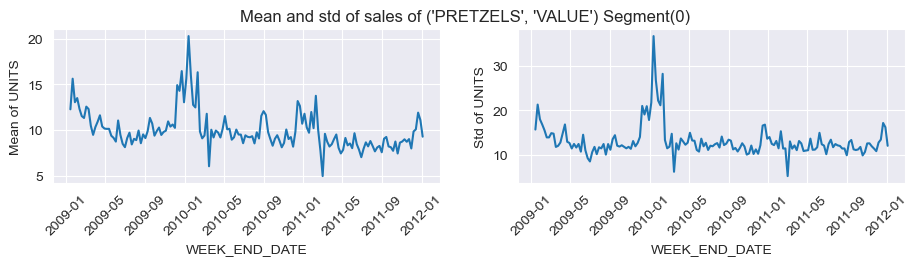

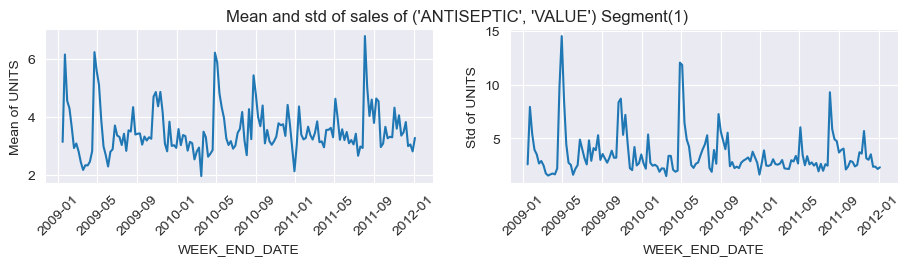

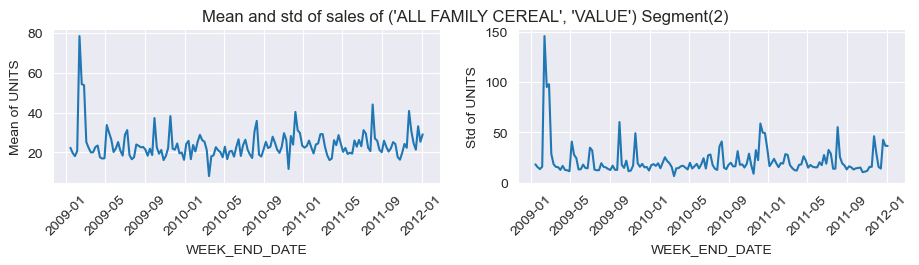

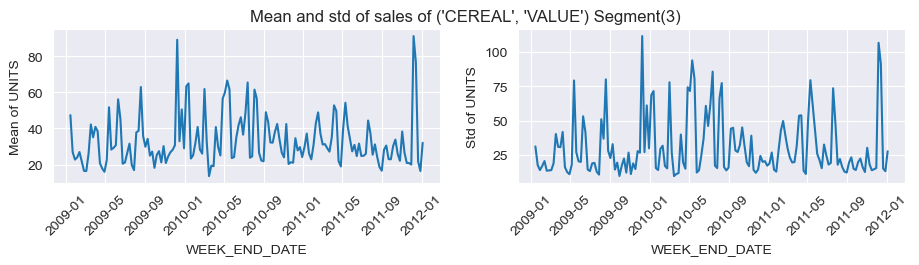

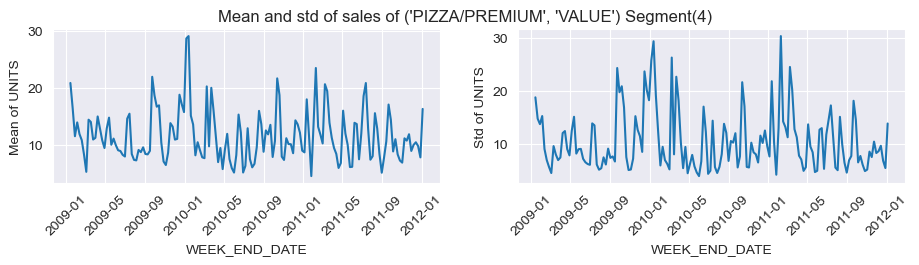

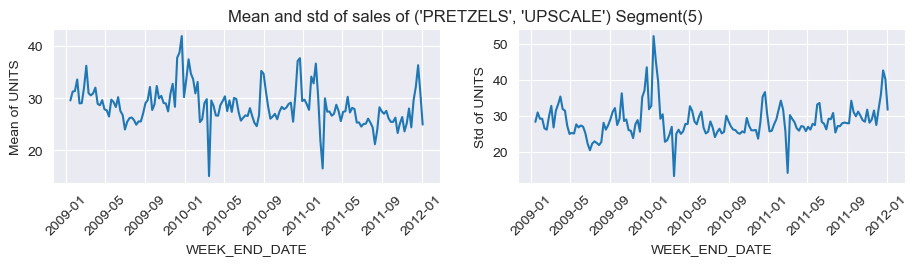

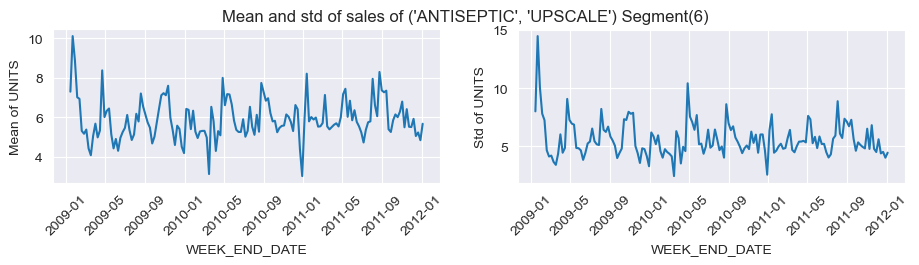

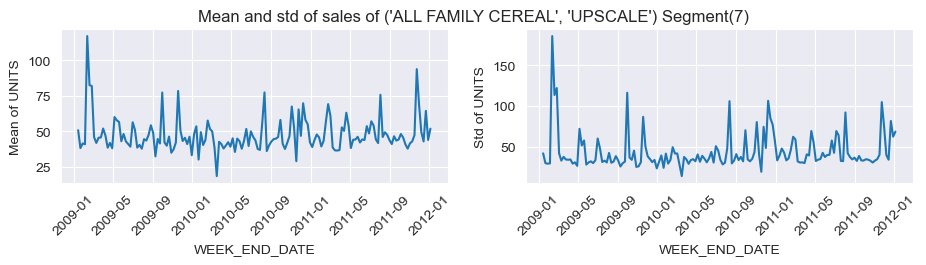

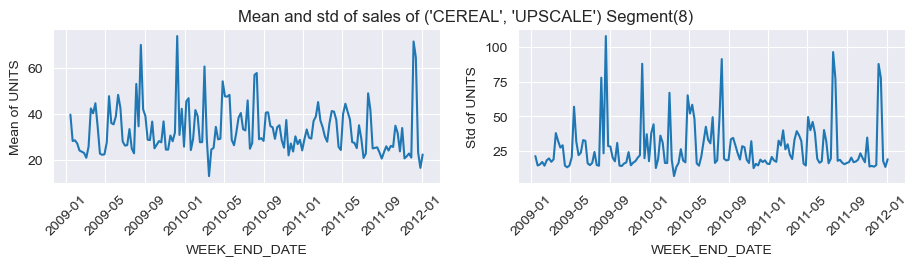

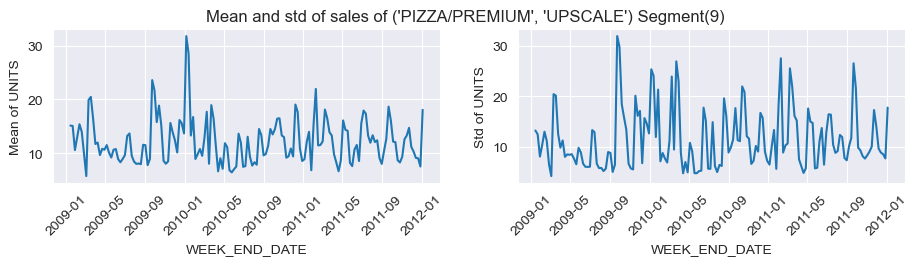

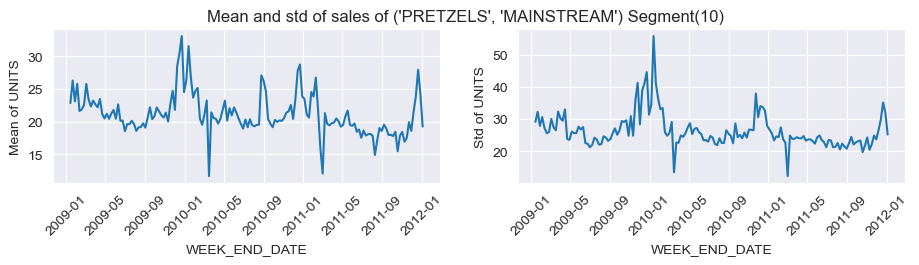

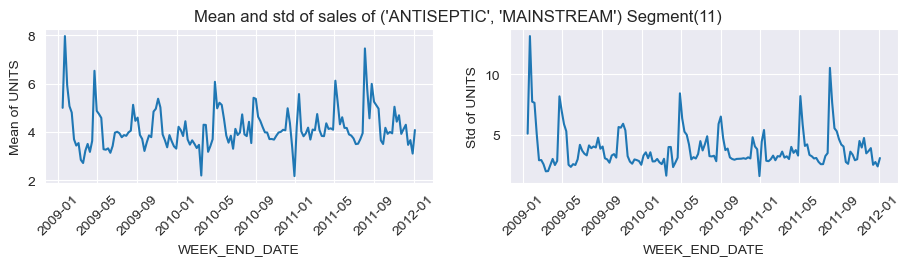

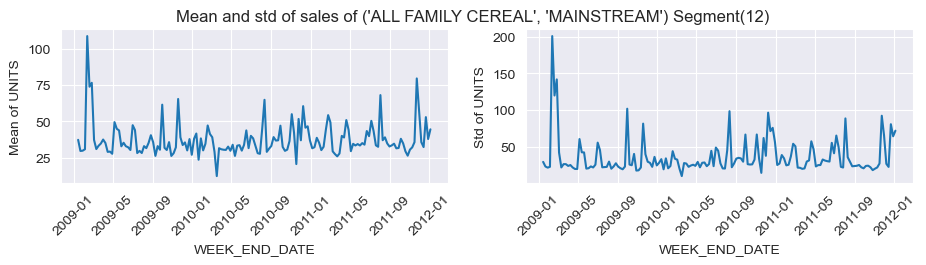

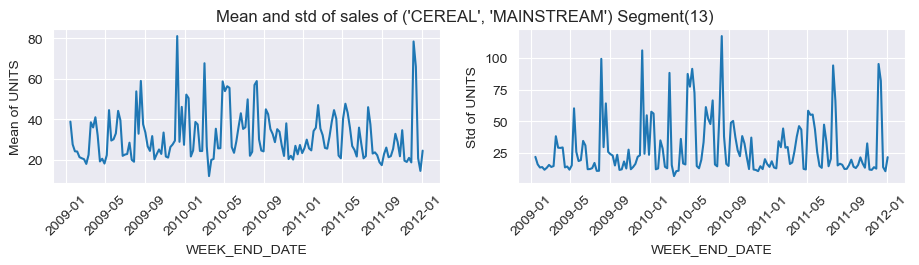

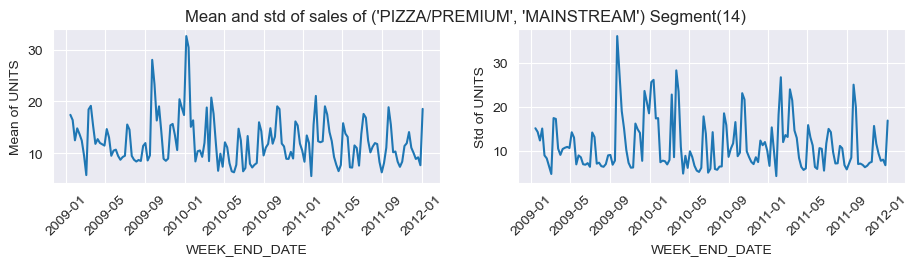

In [17]:
for idx in range(number_of_segments):
    segment = transactions_data[transactions_data['SEGMENT_ID'] == idx]
    segment_mean = segment.groupby('WEEK_END_DATE')['UNITS'].mean().to_dict()
    segment_std = segment.groupby('WEEK_END_DATE')['UNITS'].std().to_dict()

    fig, axes = plt.subplots(1, 2, figsize=(11, 2))
    fig.suptitle(f'Mean and std of sales of {segment_dict[idx]} Segment({idx})')

    axes[0].plot(segment_mean.keys(), segment_mean.values())
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_xlabel('WEEK_END_DATE')
    axes[0].set_ylabel('Mean of UNITS')

    axes[1].plot(segment_std.keys(), segment_std.values())
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_xlabel('WEEK_END_DATE')
    axes[1].set_ylabel('Std of UNITS')

# plt.savefig('mean_and_std_of_segments.pdf', bbox_inches='tight')
plt.show()


<Figure size 1000x350 with 0 Axes>

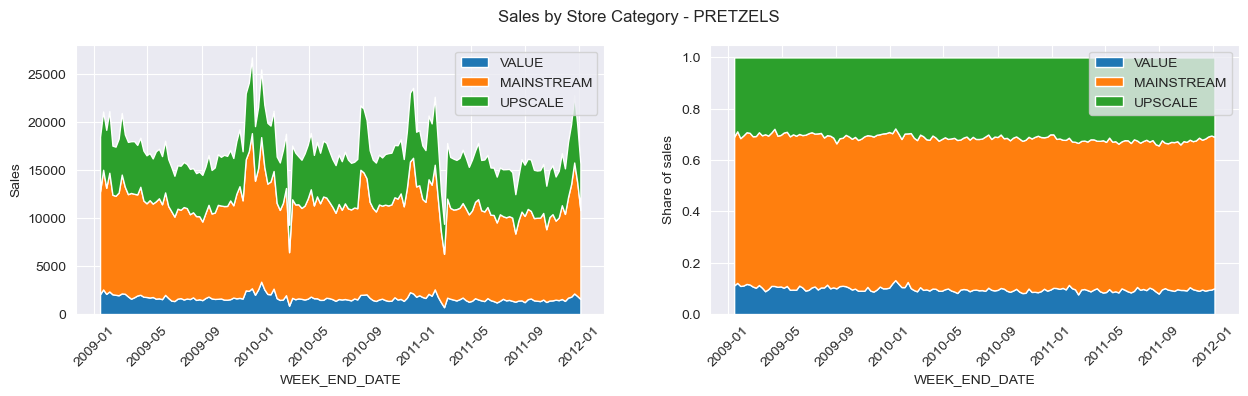

<Figure size 1000x350 with 0 Axes>

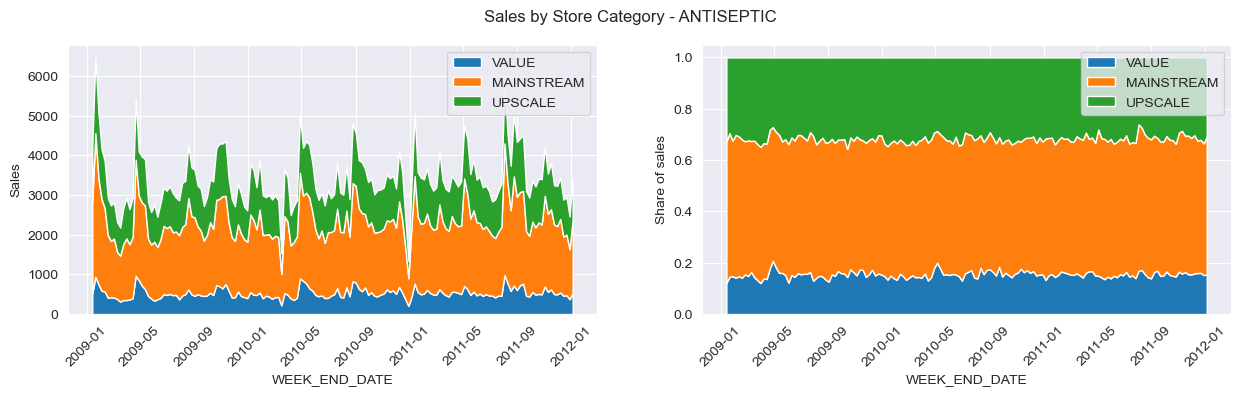

<Figure size 1000x350 with 0 Axes>

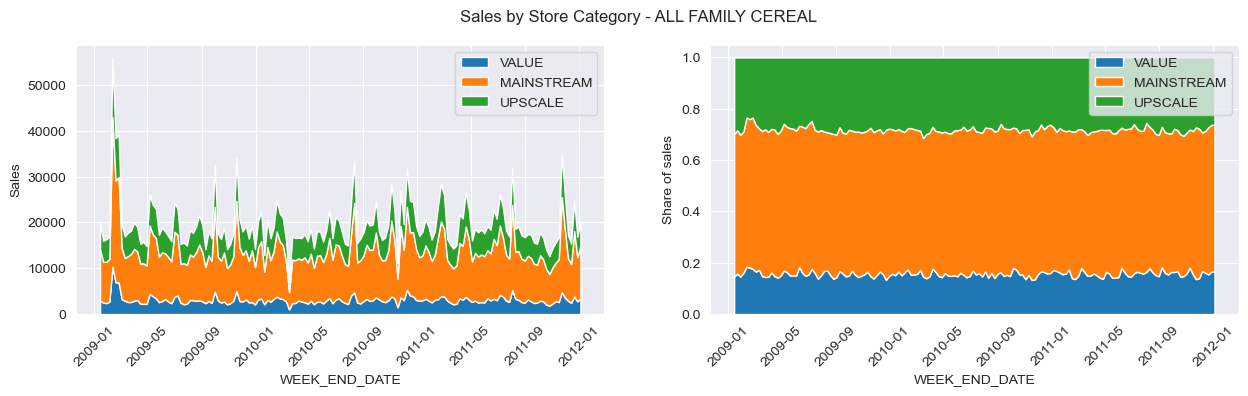

<Figure size 1000x350 with 0 Axes>

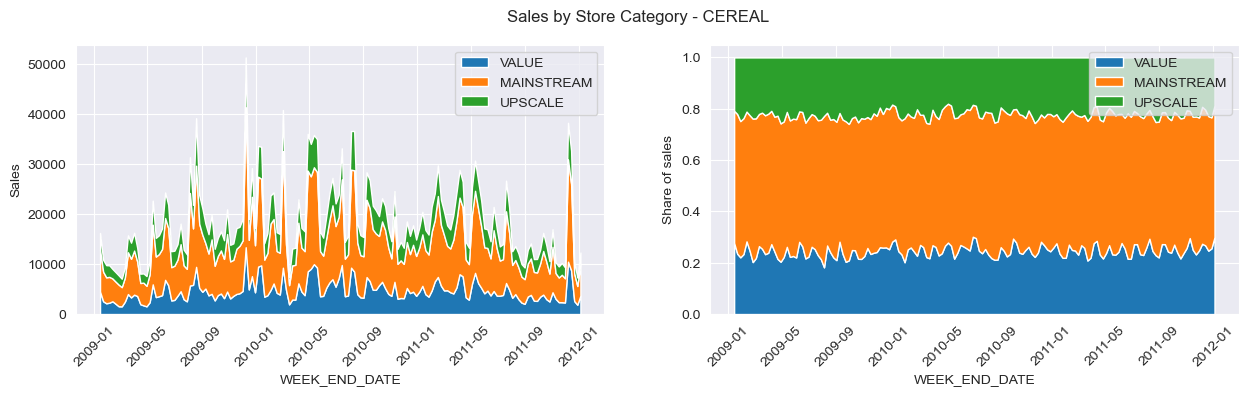

<Figure size 1000x350 with 0 Axes>

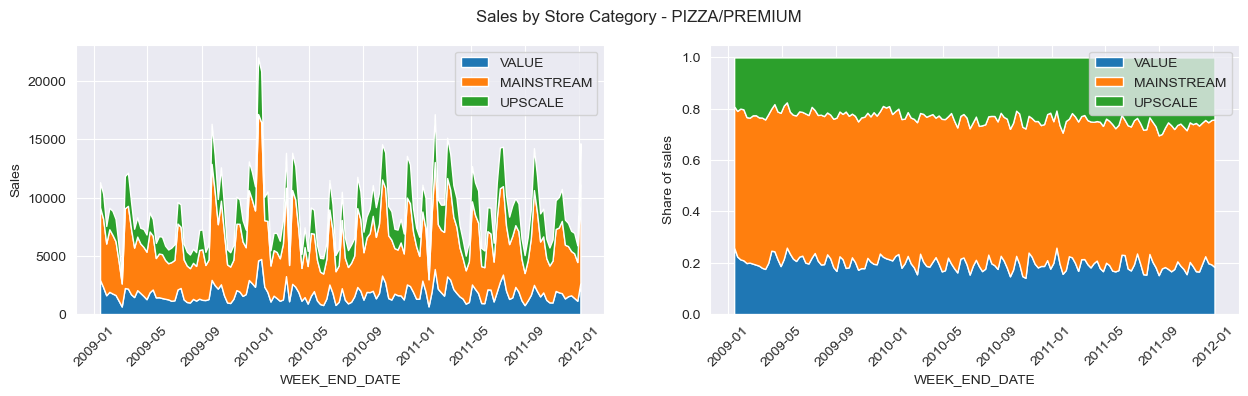

In [18]:
sub_category_list = transactions_data['SUB_CATEGORY'].unique()
for sub_category in sub_category_list:
    segment = transactions_data[transactions_data['SUB_CATEGORY'] == sub_category]
    value_shop = np.array(list(segment[segment['SEG_VALUE_NAME'] == 'VALUE'].groupby(['WEEK_END_DATE'])['UNITS'].sum().to_dict().values()))
    mainstream_shop = np.array(list(segment[segment['SEG_VALUE_NAME'] == 'MAINSTREAM'].groupby(['WEEK_END_DATE'])['UNITS'].sum().to_dict().values()))
    upscale_shop = np.array(list(segment[segment['SEG_VALUE_NAME'] == 'UPSCALE'].groupby(['WEEK_END_DATE'])['UNITS'].sum().to_dict().values()))

    value_shop_proportion = value_shop / (value_shop + mainstream_shop + upscale_shop)
    mainstream_shop_proportion = mainstream_shop / (value_shop + mainstream_shop + upscale_shop)
    upscale_shop_proportion = upscale_shop / (value_shop + mainstream_shop + upscale_shop)

    plt.figure(figsize=(10, 3.5))
    fig, axes = plt.subplots(1, 2, figsize=(15, 3.5))
    fig.suptitle(f'Sales by Store Category - {sub_category}')
    axes[0].stackplot(
        segment['WEEK_END_DATE'].unique(),
        value_shop, mainstream_shop, upscale_shop,
        labels=['VALUE', 'MAINSTREAM', 'UPSCALE']
    )
    axes[0].set_xlabel('WEEK_END_DATE')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylabel('Sales')
    axes[0].legend(loc='upper right')

    axes[1].stackplot(
        segment['WEEK_END_DATE'].unique(),
        value_shop_proportion, mainstream_shop_proportion, upscale_shop_proportion,
        labels=['VALUE', 'MAINSTREAM', 'UPSCALE']
    )
    axes[1].set_xlabel('WEEK_END_DATE')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_ylabel('Share of sales')
    axes[1].legend(loc='upper right')

plt.show()

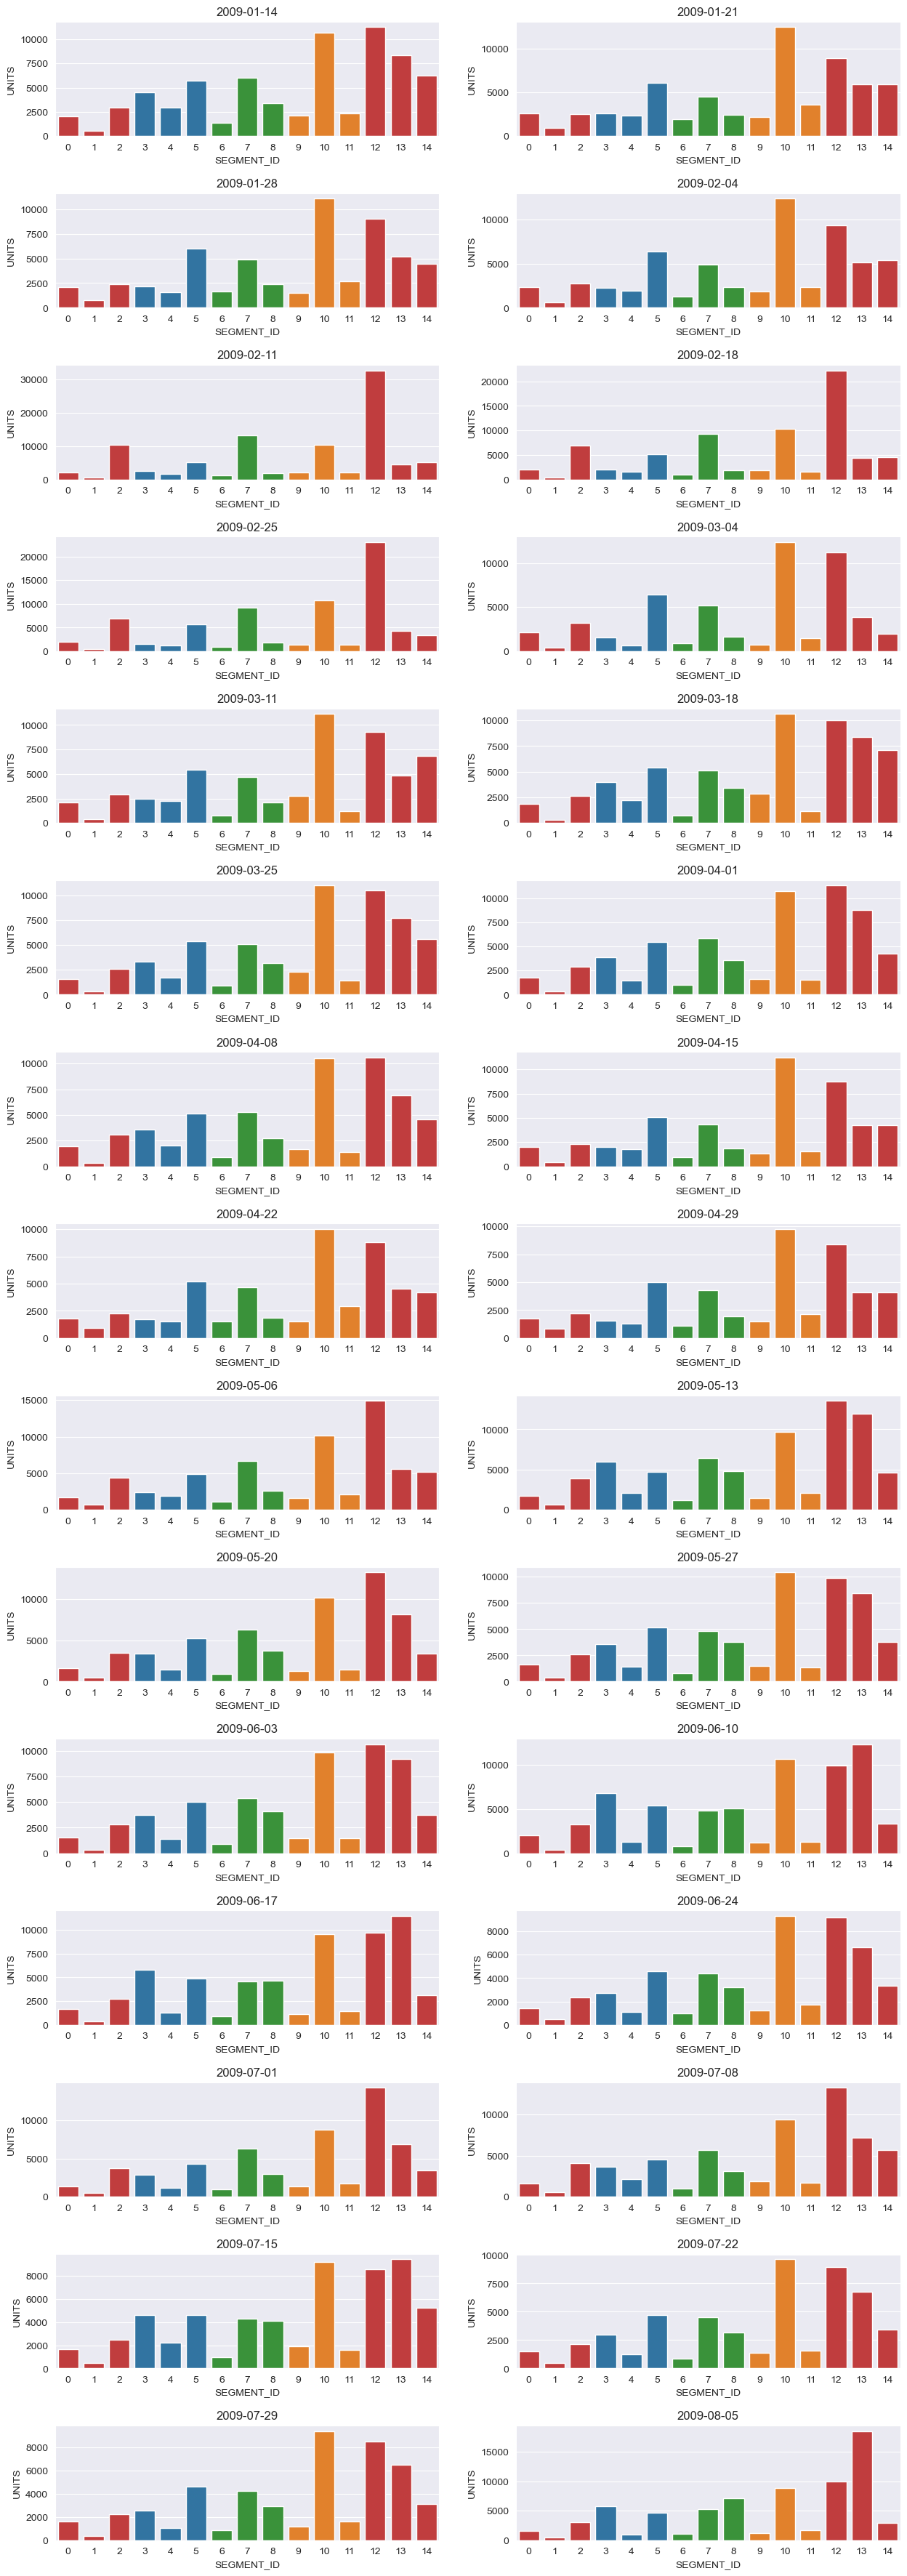

In [32]:
num_segments = transactions_data['SEGMENT_ID'].nunique()
group_colors = ['#d62728', '#1f77b4', '#2ca02c', '#ff7f0e']  # красный, синий, зеленый, оранжевый
palette = [group_colors[i // 3 % len(group_colors)] for i in range(num_segments)]

k = 30
fig, axes = plt.subplots(k // 2, 2, figsize=(15, 3 * (k // 2)), sharex=False, sharey=False)

units_sold_data = transactions_data.groupby(['WEEK_END_DATE', 'SEGMENT_ID'], as_index=False)['UNITS'].sum()
for idx, date in enumerate(transactions_data['WEEK_END_DATE'].unique()):
    if idx == k:
        break
    sns.barplot(data=units_sold_data[units_sold_data['WEEK_END_DATE'] == date],
                x='SEGMENT_ID',
                y='UNITS',
                hue='SEGMENT_ID',
                palette=palette,
                ax=axes[idx // 2, idx % 2],
                dodge=False)
    axes[idx // 2, idx % 2].legend_.remove()
    axes[idx // 2, idx % 2].set_title(f"{str(date)[:-19]}", fontsize=12)  

plt.subplots_adjust(hspace=0.5)
plt.show()

Сформируем данные для обучения модели

In [33]:
transactions_data.sample(3)

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,SEG_VALUE_NAME,SUB_CATEGORY,SEGMENT_ID
205057,2010-03-17,15531,1600027528,7,7,7,32.13,4.59,4.59,0,0,0,VALUE,ALL FAMILY CEREAL,2
121133,2009-09-30,2513,3000006560,8,8,8,20.72,2.59,2.59,0,0,0,UPSCALE,CEREAL,8
94962,2009-08-05,11757,3800039118,350,261,254,581.00,1.66,3.19,1,1,0,MAINSTREAM,CEREAL,13


In [35]:
grouped = transactions_data.groupby(['SEGMENT_ID', 'WEEK_END_DATE', 'STORE_NUM']).sum()

In [37]:
grouped

UPC  UNITS  VISITS  HHS    SPEND  \
SEGMENT_ID WEEK_END_DATE STORE_NUM                                             
0          2009-01-14    367        35822681867     81      69   69   132.77   
                         2523        9013038019     60      49   44    80.15   
                         4259       50647496619    152     130  128   246.59   
                         6431       35245558610    107     103  102   148.80   
                         8035       17387661089     25      21   21    35.78   
...                                         ...    ...     ...  ...      ...   
14         2012-01-04    25261      52762355808    241     196  195  1031.62   
                         26973      50696155276    202     177  176   956.07   
                         26981      50696155276    191     155  155   886.70   
                         28909      50696155277    268     224  224  1258.53   
                         29159      50696155277    148     120  117   706.54   

                                    PRICE  BASE_PRICE  FEATURE  DISPLAY  \
SEGMENT_ID WEEK_END_DATE STORE_NUM                                        
0          2009-01-14    367        15.27       18.22        0        0   
                         2523        8.64        8.64        0        0   
                         4259       19.62       21.22        0        0   
                         6431       18.27       19.13        0        0   
                         8035        7.12       10.73        0        0   
...                                   ...         ...      ...      ...   
14         2012-01-04    25261      60.79       68.11        9        5   
                         26973      54.90       65.09        9        4   
                         26981      54.21       64.36        9        7   
                         28909      54.26       63.97        9        0   
                         29159      53.97       63.11        9        8   

                                    TPR_ONLY  
SEGMENT_ID WEEK_END_DATE STORE_NUM            
0          2009-01-14    367               5  
                         2523              0  
                         4259              4  
                         6431              3  
                         8035              2  
...                                      ...  
14         2012-01-04    25261             0  
                         26973             0  
                         26981             0  
                         28909             0  
                         29159             0  

[61494 rows x 10 columns]

In [39]:
def get_cost(row):
    return (row['BASE_PRICE'] - row['PRICE']) / row['BASE_PRICE'] * 100

a = grouped.apply(get_cost, axis=1)#.droplevel(level=1)#.droplevel(level=1)
a = a.reset_index()
a.rename(columns={0: 'SEGMENT_COST'}, inplace=True)
a

,SEGMENT_ID,WEEK_END_DATE,STORE_NUM,SEGMENT_COST
0,0,2009-01-14,367,16.190999
1,0,2009-01-14,2523,0.000000
2,0,2009-01-14,4259,7.540057
3,0,2009-01-14,6431,4.495557
4,0,2009-01-14,8035,33.643989
...,...,...,...,...
61489,14,2012-01-04,25261,10.747321
61490,14,2012-01-04,26973,15.655247
61491,14,2012-01-04,26981,15.770665
61492,14,2012-01-04,28909,15.178990


In [40]:
b = grouped['SPEND']
b = b.reset_index()
b

,SEGMENT_ID,WEEK_END_DATE,STORE_NUM,SPEND
0,0,2009-01-14,367,132.77
1,0,2009-01-14,2523,80.15
2,0,2009-01-14,4259,246.59
3,0,2009-01-14,6431,148.80
4,0,2009-01-14,8035,35.78
...,...,...,...,...
61489,14,2012-01-04,25261,1031.62
61490,14,2012-01-04,26973,956.07
61491,14,2012-01-04,26981,886.70
61492,14,2012-01-04,28909,1258.53


In [41]:
c = grouped.groupby(['SEGMENT_ID', 'WEEK_END_DATE'])['SPEND'].sum()
c = pd.DataFrame(c).reset_index()
c

,SEGMENT_ID,WEEK_END_DATE,SPEND
0,0,2009-01-14,3254.04
1,0,2009-01-21,3553.22
2,0,2009-01-28,3034.46
3,0,2009-02-04,3708.63
4,0,2009-02-11,3419.07
...,...,...,...
2335,14,2011-12-07,22042.42
2336,14,2011-12-14,19438.01
2337,14,2011-12-21,19183.96
2338,14,2011-12-28,16877.90


In [ ]:
def get_market_share(row):
    return (row['SPEND'] / c[(c['WEEK_END_DATE'] == row['WEEK_END_DATE']) & (c['SEGMENT_ID'] == row['SEGMENT_ID'])]['SPEND']).iloc[0]

dataset = pd.DataFrame(columns=['SEGMENT_ID', 'WEEK_END_DATE', 'STORE_NUM', 'SEGMENT_COST', 'MARKET_SHARE'])
dataset['SEGMENT_ID'] = a['SEGMENT_ID']
dataset['WEEK_END_DATE'] = a['WEEK_END_DATE']
dataset['STORE_NUM'] = a['STORE_NUM']
dataset['SEGMENT_COST'] = a['SEGMENT_COST']
dataset['MARKET_SHARE'] = b.apply(get_market_share, axis=1)
dataset

,SEGMENT_ID,WEEK_END_DATE,STORE_NUM,SEGMENT_COST,MARKET_SHARE
0,0,2009-01-14,367,16.190999,0.040802
1,0,2009-01-14,2523,0.000000,0.024631
2,0,2009-01-14,4259,7.540057,0.075780
3,0,2009-01-14,6431,4.495557,0.045728
4,0,2009-01-14,8035,33.643989,0.010996
...,...,...,...,...,...
61489,14,2012-01-04,25261,10.747321,0.026903
61490,14,2012-01-04,26973,15.655247,0.024932
61491,14,2012-01-04,26981,15.770665,0.023123
61492,14,2012-01-04,28909,15.178990,0.032820


In [ ]:
dataset = pd.read_csv('dataset_extended.csv')
dataset = dataset[dataset['SEGMENT_COST'] >= 0]

In [ ]:
number_of_segments = 15
df_segments = []
for segment_id in range(number_of_segments):
    df_segments.append(dataset[dataset['SEGMENT_ID'] == segment_id])

train_size_grid = np.linspace(0.05, 0.95, 19)
X_train_set = {train_size: pd.DataFrame() for train_size in train_size_grid}
X_test_set = {train_size: pd.DataFrame() for train_size in train_size_grid}
for i, segment in enumerate(df_segments):
    for train_size in train_size_grid:
        '''
            Из каждого сегмента берем нужный процент данных для обучающей выборки, 
            сохраняем это для обучения нейросети
        '''
        X_train = segment[:int(segment.shape[0] * train_size)]
        X_test = segment[int(segment.shape[0] * train_size):]

        X_train_set[train_size] = pd.concat([X_train_set[train_size], X_train], ignore_index=True)
        X_test_set[train_size] = pd.concat([X_test_set[train_size], X_test], ignore_index=True) 

In [ ]:
class A_Net(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super(A_Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        a = torch.sigmoid(self.fc_out(x))
        return a
    
class LogReg():
    def __init__(self, max_iter=15000, learning_rate=0.01, tol=0.00001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.thetas = np.zeros(2)
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None

    def fit(self, x, y, a):
        x, y = x.copy(), y.copy()
        self.add_ones(x)
        thetas = np.zeros(x.shape[1])
        self.thetas[0] = a
        thetas[0] = a
        self.m = np.zeros_like(thetas)
        self.v = np.zeros_like(thetas)
        n = x.shape[0]

        for t in range(1, self.max_iter + 1):
            y_pred = self.h(x, thetas)
            grad = self.gradient(x, y, y_pred, n)

            self.m = self.beta1 * self.m + (1 - self.beta1) * grad
            self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)

            m_hat = self.m / (1 - self.beta1 ** t)
            v_hat = self.v / (1 - self.beta2 ** t)

            thetas -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            self.thetas = thetas

            if self.loss(y, y_pred) < self.tol:
                break

    def predict(self, x):
        x = x.copy()
        self.add_ones(x)
        z = np.dot(x, self.thetas)
        probs = np.array([expit(value) for value in z])
        return probs

    def add_ones(self, x):
        return x.insert(0, 'x0', np.ones(x.shape[0]))

    def loss(self, y, y_pred):
        y_one_loss = y * np.log(y_pred + 1e-9)
        y_zero_loss = (1 - y) * np.log(1 - y_pred + 1e-9)
        return -np.mean(y_zero_loss + y_one_loss)

    def h(self, x, thetas):
        z = np.dot(x, thetas)
        return np.array([expit(value) for value in z])

    def gradient(self, x, y, y_pred, n):
        return np.dot(x.T, (y_pred - y)) / n

    
class LogReg_b():
    def __init__(self, max_iter=15000, learning_rate=0.01, tol=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.thetas = None
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None

    def fit(self, x, y, a):
        x, y = x.copy(), y.copy()
        self.add_ones(x)
        thetas = np.zeros(x.shape[1])
        self.thetas = np.zeros(x.shape[1])
        self.thetas[0] = a
        thetas[0] = a
        self.m = 0 #np.zeros_like(thetas)
        self.v = 0 #np.zeros_like(thetas)
        n = x.shape[0]

        for t in range(1, self.max_iter + 1):
            y_pred = self.h(x, thetas)
            grad = self.gradient(x, y, y_pred, n)

            self.m = self.beta1 * self.m + (1 - self.beta1) * grad[1]
            self.v = self.beta2 * self.v + (1 - self.beta2) * (grad[1] ** 2)

            m_hat = self.m / (1 - self.beta1 ** t)
            v_hat = self.v / (1 - self.beta2 ** t)

            thetas[1] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            self.thetas = thetas

            if self.loss(y, y_pred) < self.tol:
                break

    def predict(self, x):
        x = x.copy()
        self.add_ones(x)
        z = np.dot(x, self.thetas)
        probs = np.array([expit(value) for value in z])
        return probs

    def add_ones(self, x):
        return x.insert(0, 'x0', np.ones(x.shape[0]))

    def loss(self, y, y_pred):
        y_one_loss = y * np.log(y_pred + 1e-9)
        y_zero_loss = (1 - y) * np.log(1 - y_pred + 1e-9)
        return -np.mean(y_zero_loss + y_one_loss)

    def h(self, x, thetas):
        z = np.dot(x, thetas)
        return np.array([expit(value) for value in z])

    def gradient(self, x, y, y_pred, n):
        return np.dot(x.T, (y_pred - y)) / n

In [ ]:
model_params = {i: {train_size: [0, 0] for train_size in train_size_grid} for i in range(number_of_segments)}
for train_size in train_size_grid:
    if train_size != 0.05:
        continue
    df_train = X_train_set[train_size]
    df_test = X_test_set[train_size]
    
    num_segments = df_train['SEGMENT_ID'].nunique()
    
    encoder = OneHotEncoder(sparse=False)
    X_context = df_train[['SEG_VALUE_NAME', 'SUB_CATEGORY']]
    X_context_encoded = encoder.fit_transform(X_context)
    X_context_tensor = torch.tensor(X_context_encoded, dtype=torch.float32)
    
    y = df_train[['MARKET_SHARE']].values.astype(np.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    
    model = A_Net(input_dim=X_context_encoded.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    n_epochs = 200

    for epoch in tqdm(range(n_epochs)):
        model.train()
        optimizer.zero_grad()

        y_pred = model(X_context_tensor)
        loss = loss_fn(y_pred, y_tensor)
        loss.backward()
        optimizer.step()
    
    X_context_test = df_test[['SEG_VALUE_NAME', 'SUB_CATEGORY']]
    X_context_encoded_test = encoder.fit_transform(X_context_test)
    X_context_tensor_test = torch.tensor(X_context_encoded_test, dtype=torch.float32)
    
    df_test_with_preds = df_test.copy()
    with torch.no_grad():
        y_pred_test = model(X_context_tensor_test).numpy().flatten()
    df_test_with_preds['a_pred'] = y_pred_test
    segment_a_map = df_test_with_preds[['SEGMENT_ID', 'a_pred']].drop_duplicates().sort_values('SEGMENT_ID')
    segment_id_to_a_dict = segment_a_map.drop_duplicates('SEGMENT_ID').set_index('SEGMENT_ID')['a_pred'].to_dict()
    for i in range(num_segments):
        model_params[i][train_size][0] = -2 * segment_id_to_a_dict[i]

In [ ]:
train_size_grid = np.linspace(0.05, 0.95, 19)
predictions_dict = {train_size: [np.empty((0,)), np.empty((0,))] for train_size in train_size_grid}
for i, segment in tqdm(enumerate(df_segments), total=len(df_segments)):
    for train_size in train_size_grid:
        X = segment[['SEGMENT_COST']]
        y = segment['MARKET_SHARE']
        param_a = model_params[i][train_size][0]

        X_train, y_train = X[:int(X.shape[0] * train_size)],  y[:int(X.shape[0] * train_size)]
        X_test, y_test = X[int(X.shape[0] * train_size):], y[int(X.shape[0] * train_size):]

        logreg = LogReg_b()
        logreg.fit(X_train, y_train, param_a)

        model_params[i][train_size][1] = logreg.thetas[1]

        y_pred = logreg.predict(X_test)

        predictions_dict[train_size][0] = np.concatenate((predictions_dict[train_size][0], y_pred))
        predictions_dict[train_size][1] = np.concatenate((predictions_dict[train_size][1], y_test.to_numpy()))

In [ ]:
rmae_dict = {train_size: 0 for train_size in train_size_grid}
for train_size, (y_pred, y_test) in predictions_dict.items():
    rmae = (np.sum(np.abs(y_pred-y_test))) / np.sum(y_test)
    rmae_dict[train_size] = rmae
    
train_sizes = list(rmae_dict.keys())
rmae_values = list(rmae_dict.values())

# Построение графика
plt.figure(figsize=(8, 4))
sns.lineplot(x=train_sizes, y=np.array(rmae_values)*100)
plt.title('Зависимость RMAE от размера обучающей выборке')
plt.xlabel('train_size proportion')
plt.ylabel('RMAE(%)')

plt.show()